In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
%matplotlib inline

Реализация коэффициентов Крамера и Мэтьюса

In [2]:
def cramer(chi2, n, k1, k2):
    return np.sqrt(chi2 / (n * min(k1, k2) - 1))

def matthews(table2x2):
    table2x2 = np.array(table2x2)
    a, b = table2x2[0]
    c, d = table2x2[1]
    return (a*d - b*c) / np.sqrt((a+b) * (a+c) * (b+d) * (c+d))

# Отток клиентов телекома

Данные https://github.com/Yorko/mlcourse_open/blob/master/data/telecom_churn.csv

In [3]:
telecom = pd.read_csv('./telecom_churn.csv')
telecom.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Количество клиентов в данных

In [4]:
n = len(telecom)
n

3333

### Зависимость оттока от количества звонков в службу поддержки

Гистограмма количества звонков в службу поддержки для клиентов в оттоке и не в оттоке.
Как видим, клиенты из оттока в среднем чаще совершают звонки в службу поддержки.

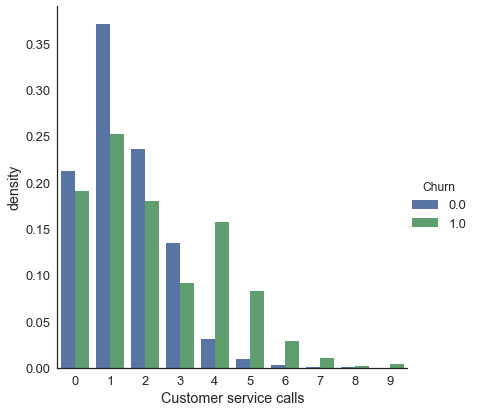

In [5]:
d1, x1 = np.histogram(telecom[telecom['Churn']]['Customer service calls'], 
                      range=(0, 10), bins=10, normed=True)
d2, x2 = np.histogram(telecom[~telecom['Churn']]['Customer service calls'], 
                      range=(0, 10), bins=10, normed=True)
dens = pd.DataFrame(np.array([np.append(d1, d2), 
                              np.append(x1[:-1], x2[:-1]),
                              [1]*10 + [0]*10]).T,
                    columns=['density', 'Customer service calls', 'Churn'])

sns.set(style='white', font_scale=1.3)
sns.factorplot(data=dens, x='Customer service calls', y='density', 
               hue='Churn', kind='bar', size=6)
plt.xticks(np.arange(10), np.arange(10).astype(str));

Будем применять критерий хи-квадрат. Подадим таблицу как есть, и проверим применимость. Доля клеток, в которых ожидаемое количество меньше 5 получилась больше 20%, поэтому надо делать объединения клеток.

In [6]:
obs = pd.crosstab(telecom['Churn'], 
                  telecom['Customer service calls'])

chi2, p, dof, expected = sps.chi2_contingency(obs)
(expected < 5).mean()

0.3

In [7]:
obs

Customer service calls,0,1,2,3,4,5,6,7,8,9
Churn,,,,,,,,,,
False,605,1059,672,385,90,26,8,4,1,0
True,92,122,87,44,76,40,14,5,1,2


Объединяем два последних столбца

In [8]:
obs['>7'] = obs[8] + obs[9]
del obs[8], obs[9]

obs

Customer service calls,0,1,2,3,4,5,6,7,>7
Churn,,,,,,,,,
False,605,1059,672,385,90,26,8,4,1
True,92,122,87,44,76,40,14,5,3


Опять не получилось...

In [9]:
chi2, p, dof, expected = sps.chi2_contingency(obs)
(expected < 5).mean()

0.2222222222222222

Еще раз объединяем последние столбцы

In [10]:
obs['>6'] = obs[7] + obs['>7']
del obs[7], obs['>7']

obs

Customer service calls,0,1,2,3,4,5,6,>6
Churn,,,,,,,,
False,605,1059,672,385,90,26,8,5
True,92,122,87,44,76,40,14,8


На этот раз все нормально

In [11]:
chi2, p, dof, expected = sps.chi2_contingency(obs)
(expected < 5).mean()

0.125

Получаемое число степеней свободы, все правильно

In [12]:
dof

7

Значение статистики и pvalue, **наблюдается статистически значимая зависимость**

In [13]:
chi2, p

(339.8121374370096, 1.8667121238838202e-69)

Коэффициент Крамера

In [14]:
cramer(chi2, n, 8, 2)

0.22579762345348267

### Зависимость оттока от тарифного плана

In [15]:
np.unique(telecom['International plan'])

array(['No', 'Yes'], dtype=object)

В этом случае получаем таблицу 2 на 2

In [16]:
obs = pd.crosstab(telecom['Churn'], telecom['International plan'])
obs

International plan,No,Yes
Churn,,
False,2664,186
True,346,137


Результат применения критерия хи-квадрат **статистически значим**

In [17]:
chi2, p, dof, expected = sps.chi2_contingency(obs)
chi2, p, dof

(222.5657566499376, 2.4931077033159556e-50, 1)

Коэффициенты Крамера и Мэтьюса

In [18]:
cramer(chi2, n, 2, 2), matthews(obs)

(0.1827380961935435, 0.25985184734548217)

### Зависимость оттока от тарифного плана голосовой почты

Все аналогично.

In [19]:
np.unique(telecom['Voice mail plan'])

array(['No', 'Yes'], dtype=object)

In [20]:
obs = pd.crosstab(telecom['Churn'], telecom['Voice mail plan'])
obs

Voice mail plan,No,Yes
Churn,,
False,2008,842
True,403,80


In [21]:
chi2, p, dof, expected = sps.chi2_contingency(obs)
chi2, p, dof

(34.13166001075673, 5.15063965903898e-09, 1)

Статистическая значимость имеется, в то время как практическая значимость может быть поставлена под сомнение

In [22]:
cramer(chi2, n, 2, 2), matthews(obs)

(0.07156136708398074, -0.10214814067014692)

### Зависимость оттока от количества минут днем

В данном случае нужно исследовать зависимость двух переменных, из которых одна вещественная, а другая -- бинарная.
Для начала можно построить две KDE, по которым уже видна зависимость.

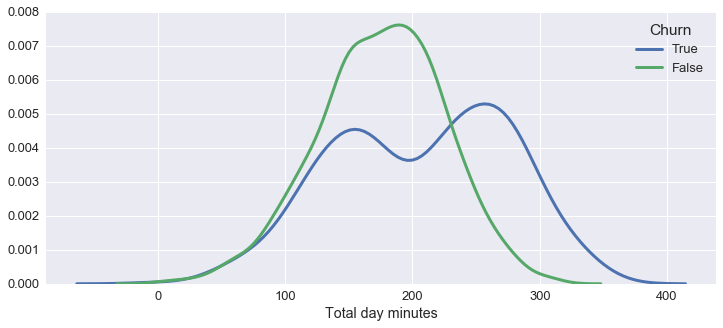

In [23]:
sns.set(font_scale=1.3)
plt.figure(figsize=(12, 5))
sns.kdeplot(telecom[telecom['Churn'] == True]['Total day minutes'], 
            label='True', lw=3)
sns.kdeplot(telecom[telecom['Churn'] == False]['Total day minutes'], 
            label='False', lw=3)
plt.xlabel('Total day minutes')
plt.legend(title='Churn');

Чтобы исследовать статистическую зависимость, разобьем вещественную переменную на несколько интервал, тем самым сведя ее к категориальной.
После этого можно построить таблицу сопряженности.

In [24]:
obs = np.histogram2d(telecom['Churn'], 
                     telecom['Total day minutes'], 
                     bins=(2, 5))[0]
obs

array([[  71.,  592., 1478.,  674.,   35.],
       [  10.,   88.,  132.,  184.,   69.]])

Применяем критерий хи-квадрат. **Статистическая значимость имеется.**

In [25]:
sps.chi2_contingency(obs)

(312.22807558569394,
 2.4931581541229795e-66,
 4,
 array([[  69.26192619,  581.45814581, 1376.68766877,  733.66336634,
           88.92889289],
        [  11.73807381,   98.54185419,  233.31233123,  124.33663366,
           15.07110711]]))

### Зависимость оттока от количества минут ночью
Все аналогично

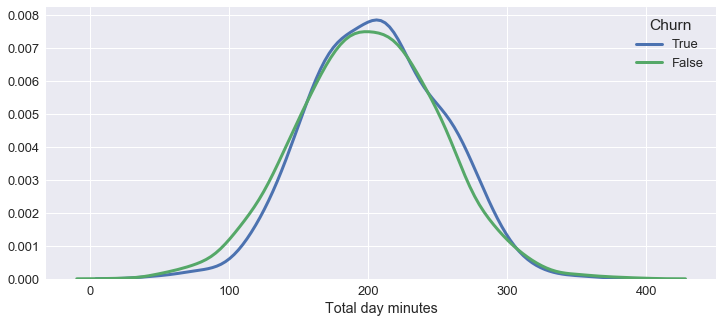

In [26]:
sns.set(font_scale=1.3)
plt.figure(figsize=(12, 5))
sns.kdeplot(telecom[telecom['Churn'] == True]['Total night minutes'], 
            label='True', lw=3)
sns.kdeplot(telecom[telecom['Churn'] == False]['Total night minutes'], 
            label='False', lw=3)
plt.xlabel('Total day minutes')
plt.legend(title='Churn');

In [27]:
obs = np.histogram2d(telecom['Churn'], 
                     telecom['Total night minutes'], 
                     bins=(2, 5))[0]
obs

array([[  62.,  772., 1499.,  488.,   29.],
       [   5.,  120.,  259.,   96.,    3.]])

In [28]:
sps.chi2_contingency(obs)

(5.992610695316391,
 0.19970079123233955,
 4,
 array([[  57.29072907,  762.73627363, 1503.24032403,  499.36993699,
           27.36273627],
        [   9.70927093,  129.26372637,  254.75967597,   84.63006301,
            4.63726373]]))

Интересно, что в этом случае **результат статистически незначим**.
Т.е. получаем, что отток зависит от дневных минут и не зависит от ночных.

### Итог:

* Зависимость оттока от количества звонков в службу поддержки --- **да**;
* Зависимость оттока от тарифного плана --- **да**;
* Зависимость оттока от тарифного плана голосовой почты --- **сомнительно**;
* Зависимость оттока от количества минут днем --- **да**;
* Зависимость оттока от количества минут ночью --- **нет**.

# Chess (King-Rook vs. King) Data Set 
https://archive.ics.uci.edu/ml/datasets/Chess+(King-Rook+vs.+King)

Данные состоят некоторого количества бинарных переменных, которые задают комбинацию в игре, а так же результата игры с такой позицией. 

In [30]:
kr_vs_kp = pd.read_csv('kr-vs-kp.data')
kr_vs_kp.head()

,bkblk,bknwy,bkon8,bkona,bkspr,bkxbq,bkxcr,bkxwp,blxwp,bxqsq,...,spcop,stlmt,thrsk,wkcti,wkna8,wknck,wkovl,wkpos,wtoeg,result
0,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
1,f,f,f,f,t,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won
2,f,f,f,f,t,f,t,f,f,f,...,f,f,f,f,f,f,t,t,n,won
3,f,f,f,f,f,f,f,f,t,f,...,f,f,f,f,f,f,t,t,n,won
4,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,n,won


Проведем анализ влияния параметров позиции на итог игры.
Для этого для каждого параметра применим критерий хи-квадрат, посчитаем коэффициенты Крамера и Мэтьюса.
К результатам применения критерия хи-квадрат применим так же МПГ по методу Холма.
Столбец `value` соответствует "положительному" значению в терминах коэффициентов Крамера и Мэтьса.

In [31]:
influence = pd.DataFrame(columns=['value', 'chi2', 'pvalue', 
                                  'reject', 'cramer', 'matthews'])
features = kr_vs_kp.columns[:-1]
n = len(kr_vs_kp)

for f in features:
    obs = pd.crosstab(kr_vs_kp[f], kr_vs_kp['result'])
    chi2, p, _, _ = sps.chi2_contingency(obs)
    series = pd.Series({'value': obs.index[0], 
                        'chi2': chi2, 
                        'pvalue': p, 
                        'reject': p < 0.05,
                        'cramer': cramer(chi2, n, 2, 2), 
                        'matthews': matthews(obs)})
    series.name = f
    influence = influence.append(series)
    
influence['reject_holm'] = multipletests(influence['pvalue'], 
                                         method='holm')[0]

In [32]:
influence['matthews_abs'] = np.abs(influence['matthews'])
influence.sort_values(by='matthews_abs', ascending=False).iloc[:, :-1]

,value,chi2,pvalue,reject,cramer,matthews,reject_holm
rimmx,f,651.435295,1.088838e-143,True,0.319265,0.452284,True
bxqsq,f,460.095072,4.583551e-102,True,0.268312,-0.380101,True
wknck,f,424.899908,2.093813e-94,True,0.257845,-0.365265,True
bkxwp,f,172.243093,2.394809e-39,True,0.164167,-0.232908,True
wkna8,f,121.752418,2.615189e-28,True,0.138024,-0.196557,True
r2ar8,f,85.803472,1.987369e-20,True,0.115869,-0.164526,True
bkxcr,f,85.100239,2.836162e-20,True,0.115393,-0.163828,True
mulch,f,78.661185,7.373009e-19,True,0.110942,-0.158337,True
wkpos,f,67.971542,1.658723e-16,True,0.103129,0.146543,True
bkxbq,f,61.903982,3.606196e-15,True,0.098418,0.139802,True


---------

Прикладная статистика и анализ данных, 2019

Никита Волков

https://mipt-stats.gitlab.io/